In [1]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import pickle
import os
import json
import numpy as np


In [2]:
cred = credentials.Certificate("../codeinterface-85b5e-firebase-adminsdk-11q7e-837ba92a03.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [23]:
docs = db.collection('responses').get()
# save docs in a pickle file called old_tasks.pkl
responses = {}
all_responses = {}
done_count = 0
for doc in docs:
    doc_dict = doc.to_dict()
    doc_dict['id'] = doc.id 
    all_responses[doc.id] = doc_dict
    if 'entered_exit_survey' and 'finalcomments'  in doc_dict:
        print(doc_dict['entered_exit_survey'])
        responses[doc.id] = doc_dict

        done_count += 1
        print(doc_dict['finalcomments'])
        print(doc_dict['howaiimproved'])



print(done_count)

Wed Jan 31 2024 22:10:53 GMT-0800 (Pacific Standard Time)
- Initially, I didn't quite realize how to use the assistant well. I later understood that I am able write comments and ask for a hint based on those comments which sped things up. 
- I was not able to copy paste the instructions. This would have saved some time.
^ Maybe both of these were intentional study design choices though.

Providing 2-3 options may be an easy one to add. The code author can choose the direction they want to take the program in.
Sun Jan 28 2024 20:34:44 GMT-0500 (Eastern Standard Time)

It could be more contextualized to the problem at hand, and it could also integrate correct documentation.
Mon Jan 29 2024 22:46:07 GMT-0800 (Pacific Standard Time)
The feedback aspect was very poor. The output section for the code was very small 2 lines so I had to scroll to see my outputs and the error messages were difficult to parse. It would show me a assertion error but since it was pure text, I had a hard time seein

In [123]:
pickle.dump(all_responses, open('responses.pkl', 'wb'))

In [37]:
all_sugg_labels = []
all_sugg_scores = []

In [38]:
import dateutil.parser as dparser


def process_log(study_data, type = "none"):
    frustration = int(study_data["frustration"])
    performance = int(study_data["performance"])
    temporal_demand = int(study_data["temporalDemand"])
    physical_demand = int(study_data["physicalDemand"])
    effort = int(study_data["effort"])
    mental_demand = int(study_data["mentalDemand"])
    tlx_score = get_tlx_score(frustration, performance, temporal_demand, physical_demand, effort, mental_demand)
    #print("TLX Score: ", tlx_score)


    completed_time = 1#dparser.parse(study_data["completed_task_time"], fuzzy=True)
    date_performed = 1#dparser.parse(study_data["date_performed"], fuzzy=True)
    study_completion = 1#get_completion_time(date_performed, completed_time)
    #print("Completion Time: ", study_completion)


    tasks_completed = get_tasks_completed(study_data["telemetry_data"])
    #print("Tasks Completed: ", tasks_completed)

    tasks_attempted = get_tasks_attempted(study_data["telemetry_data"])
    #print("Tasks Attempted: ", tasks_attempted)

    time_to_completion, avg_time_to_completion = get_time_to_completion(study_data["telemetry_data"])
    #print("Time To Completion: ", time_to_completion)
    #print("Average Time To Completion: ", avg_time_to_completion)

    tasks_skipped = get_tasks_skipped(study_data["telemetry_data"])
    #print("Tasks Skipped: ", tasks_skipped)

    coding_time = get_coding_time(study_data["telemetry_data"])
    #print("Coding Time: ", coding_time)
    additional_metrics = {}
    if type == "autocomplete":
        accept_rate, sugg_labels, sugg_probs = get_suggestion_acceptance_rate(study_data["telemetry_data"])
        additional_metrics = {
            "accept_rate": accept_rate,
        }
        all_sugg_labels.extend(sugg_labels)
        all_sugg_scores.extend(sugg_probs)
    
    if type == "chat":
        # count 'assistant_response', 'copy_code' event types in telemetry_data
        assistant_response_count = len([event for event in study_data["telemetry_data"] if event["event_type"] == "assistant_response"])
        copy_code_count = len([event for event in study_data["telemetry_data"] if event["event_type"] == "copy_code"])
        paste_into_editor_count = len([event for event in study_data["telemetry_data"] if event["event_type"] == "paste_into_editor"])
        additional_metrics = {
            "assistant_response_count": assistant_response_count,
            "copy_code_count": copy_code_count,
            "paste_into_editor_count": paste_into_editor_count,
        }
    	
    if type == "chat" or type == "autocomplete":
        # aihelpful 
        aihelpful = int(study_data["aihelpful"])
        additional_metrics["aihelpful"] = aihelpful



    dict_metrics  = {

        "tlx_score": tlx_score,
        "study_completion": study_completion,
        "tasks_completed": tasks_completed,
        "tasks_attempted": tasks_attempted,
        "time_to_completion": time_to_completion,
        "avg_time_to_completion": avg_time_to_completion,
        "tasks_skipped": tasks_skipped,
        "coding_time": coding_time,
        **additional_metrics
    }
    return dict_metrics

def get_tlx_score(frustration, performance, temporal_demand, physical_demand, effort, mental_demand):
    return (frustration + performance + temporal_demand  + effort + mental_demand) * 5


def convert_tool_usage_to_str(tool_usage):
    if tool_usage == "1":
        return "Strongly Disagree"
    elif tool_usage == "2":
        return "Disagree"
    elif tool_usage == "3":
        return "Neutral"
    elif tool_usage == "4":
        return "Agree"
    elif tool_usage == "5":
        return "Strongly Agree"
    else:
        raise ValueError("Invalid tool usage")


def get_completion_time(start_time, end_time):
    return end_time - start_time


def get_suggestion_acceptance_rate(telemetry_data):
    num_accept = len([event for event in telemetry_data if event["event_type"] == "accept"])
    # only count suggestion_shown when suggestion is not ""
    num_suggestion_shown = len([event for event in telemetry_data if event["event_type"] == "suggestion_shown" and event["suggestion"] != ""])
    suggestion_ids_shown = [event["suggestion_id"] for event in telemetry_data if event["event_type"] == "suggestion_shown" and event["suggestion"] != ""]
    suggestion_log_probs = [event["logprobs"]['firstElement'] for event in telemetry_data if event["event_type"] == "suggestion_shown" and event["suggestion"] != ""]
    sugggestion_ids_accepted = [event["suggestion_id"] for event in telemetry_data if event["event_type"] == "accept"]
    sugggestion_ids_rejected = [event["suggestion_id"] for event in telemetry_data if event["event_type"] == "reject"]
    accepted = 0
    shown_true = 0
    suggestion_labels = []
    suggestion_probs = []
    for suggestion_id in suggestion_ids_shown:
        if suggestion_id in sugggestion_ids_accepted:
            accepted += 1
            suggestion_labels.append(1)
            suggestion_probs.append(suggestion_log_probs[suggestion_ids_shown.index(suggestion_id)])
        elif suggestion_id in sugggestion_ids_rejected:
            suggestion_labels.append(0)
            suggestion_probs.append(suggestion_log_probs[suggestion_ids_shown.index(suggestion_id)])
        if suggestion_id in sugggestion_ids_rejected or suggestion_id in sugggestion_ids_accepted:
            shown_true += 1

    return accepted / shown_true, suggestion_labels, suggestion_probs


def get_tasks_completed(telemetry_data):
    return len(
        [event for event in telemetry_data if event["event_type"] == "submit_code" and event["completed_task"] == 1]
    )


def get_tasks_attempted(telemetry_data):
    return len([event for event in telemetry_data if event["event_type"] == "load_task"])


def get_time_to_completion(telemetry_data):
    starts = [event for event in telemetry_data if event["event_type"] == "load_task"]
    ends = [
        event#["timestamp"]
        for event in telemetry_data
        if event["event_type"] == "submit_code" and event["completed_task"] == 1
    ]
    times_tasks_solved = []
    task_indices_seen = set()
    for start in starts:
        if start["task_index"] == -1 or start["task_index"] in task_indices_seen:
            continue
        task_indices_seen.add(start["task_index"])
        
        for end in ends:
            if end["task_index"] == start["task_index"]:
                # check if tim is more than 10mins
                if (end["timestamp"] - start["timestamp"]) / 1000 < 600:
                    times_tasks_solved.append((end["timestamp"] - start["timestamp"]) / 1000)
                    break


    if len(times_tasks_solved) == 0:
        return [np.nan], np.nan
    return times_tasks_solved, np.mean(times_tasks_solved)


def get_coding_time(telemetry_data):
    # Get first load task
    start = [event["timestamp"] for event in telemetry_data if event["event_type"] == "load_task"][0]

    # Get last telemetry event
    end = telemetry_data[-1]["timestamp"]

    return (end - start) / 1000


def get_tasks_skipped(telemetry_data):
    return len([event for event in telemetry_data if event["event_type"] == "skip_task"])


def get_tasks_skipped(telemetry_data):
    return len([event for event in telemetry_data if event["event_type"] == "skip_task"])


def get_time_verifying_suggestion(telemetry_data):
    # Get suggestions
    suggestions_shown = [event for event in telemetry_data if event["event_type"] == "suggestion_shown"]

    suggestions_reviewed = [
        event for event in telemetry_data if event["event_type"] == "reject" or event["event_type"] == "accept"
    ]

    # Create a hashmap for suggestion reviews.
    reviewed_hashmap = {}
    for event in suggestions_reviewed:
        reviewed_hashmap[event["suggestion_id"]] = event["timestamp"]

    # Create a hashmap for times to completion
    time_spent_verifying = {}
    for event in suggestions_shown:
        if event["suggestion_id"] in reviewed_hashmap:
            time_spent_verifying[event["suggestion_id"]] = (
                reviewed_hashmap[event["suggestion_id"]] - event["timestamp"]
            ) / 1000
        else:
            print("No review found for suggestion: ", event["suggestion_id"])

    return time_spent_verifying


In [ ]:
autoocomplete_gpt35_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'accept_rate': [], 'aihelpful': []}
autocomplete_llama34_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'accept_rate': [], 'aihelpful': []}
autocomplete_llama7_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'accept_rate': [], 'aihelpful': []}
chat_gpt35_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'assistant_response_count': [], 'copy_code_count': [], 'paste_into_editor_count': [],  'aihelpful': []}
chat_llama34_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'assistant_response_count': [], 'copy_code_count': [], 'paste_into_editor_count': [],  'aihelpful': []}
chat_llama7_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'assistant_response_count': [], 'copy_code_count': [], 'paste_into_editor_count': [],  'aihelpful': []}
nomodel_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': []}
total_participants = 0
for resp in responses.values():
    if 'entered_exit_survey' not in resp or 'finalcomments' not in resp:
        continue
    resp_id = resp['id']
    #print(resp_id)
    log_metrics = process_log(resp)
    if 'test' in resp['name'] or 'test' in resp['email']:
        continue
    #if 'Nathan Gandawa' in resp['name'] or 'nathangandawa' in resp['email']:
    #    continue
    #if 'leek' in resp['name'] or 'leek' in resp['email']:
    #    continue
    if log_metrics['tasks_completed'] <1:
        print(f'name {resp["name"]} email {resp["email"]} id {resp_id} completed {log_metrics["tasks_completed"]} tasks')
        continue
    if total_participants < 10:
        print(resp['telemetry_data'])
    #print(resp['telemetry_data'])
    # get event types
    total_participants += 1
    #print(f'event types {set([event["event_type"] for event in resp["telemetry_data"]])}')
    if 'autocomplete_gpt35' in resp_id:
        autoocomplete_gpt35_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="autocomplete")
        # merge dicts
        for key in log_metrics:
            autoocomplete_gpt35_metrics[key].append(log_metrics[key])
        if log_metrics['accept_rate'] <0.001:
            print(f'never accepted sug for {resp_id} name {resp["name"]} email {resp["email"]} completed {log_metrics["tasks_completed"]} tasks')
            
    elif 'autocomplete_llama34' in resp_id:
        autocomplete_llama34_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="autocomplete")

        if log_metrics['accept_rate'] <0.001:
            print(f'never accepted sug for {resp_id} name {resp["name"]} email {resp["email"]} completed {log_metrics["tasks_completed"]} tasks')
        else:
            for key in log_metrics:
                autocomplete_llama34_metrics[key].append(log_metrics[key])
    elif 'autocomplete_llama7' in resp_id:
        autocomplete_llama7_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="autocomplete")
        for key in log_metrics:
            autocomplete_llama7_metrics[key].append(log_metrics[key])
        if log_metrics['accept_rate'] <0.001:
            print(f'never accepted sug for {resp_id} name {resp["name"]} email {resp["email"]} completed {log_metrics["tasks_completed"]} tasks')
    elif 'chat_gpt35' in resp_id:
        chat_gpt35_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="chat")
        for key in log_metrics:
            chat_gpt35_metrics[key].append(log_metrics[key])
        if log_metrics['assistant_response_count'] < 1:
            print(f'never responded sug for {resp_id} name {resp["name"]} email {resp["email"]} completed {log_metrics["tasks_completed"]} tasks')
            # print all events with type paste_into_editor
            for event in resp["telemetry_data"]:
                if event["event_type"] == "paste_into_editor":
                    print(event)
    elif 'chat_llama34' in resp_id:
        chat_llama34_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="chat")
        for key in log_metrics:
            chat_llama34_metrics[key].append(log_metrics[key])
        if log_metrics['assistant_response_count'] < 1:
            print(f'never responded sug for {resp_id} name {resp["name"]} email {resp["email"]} completed {log_metrics["tasks_completed"]} tasks')
            for event in resp["telemetry_data"]:
                if event["event_type"] == "paste_into_editor":
                    print(event)
    elif 'chat_llama7' in resp_id:
        chat_llama7_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="chat")
        for key in log_metrics:
            chat_llama7_metrics[key].append(log_metrics[key])
        if log_metrics['assistant_response_count'] < 1:
            print(f'never responded sug for {resp_id} name {resp["name"]} email {resp["email"]} completed {log_metrics["tasks_completed"]} tasks')
            for event in resp["telemetry_data"]:
                if event["event_type"] == "paste_into_editor":
                    print(event)
    elif 'nomodel' in resp_id:
        nomodel_metrics['num_responses'] += 1
        log_metrics = process_log(resp)
        for key in log_metrics:
            nomodel_metrics[key].append(log_metrics[key])
    else:
        print('no model found for response ' + resp_id)

print(f'total participants {total_participants}')

[{'task_index': -1, 'task_id': 'autocomplete_gpt35_0_3', 'event_type': 'load_task', 'timestamp': 1706765750714}, {'task_index': -1, 'event_type': 'save_code', 'timestamp': 1706765765261, 'code': 'def sum_product(numbers):'}, {'task_index': -1, 'suffix_code': '', 'event_type': 'before_shown', 'suggestion_id': 1, 'timestamp': 1706765804029, 'prefix_code': 'def sum_product(numbers):\n    return '}, {'task_index': -1, 'event_type': 'save_code', 'timestamp': 1706765810256, 'code': 'def sum_product(numbers):\n    return [s'}, {'task_index': -1, 'suffix_code': '', 'event_type': 'before_shown', 'suggestion_id': 2, 'timestamp': 1706765815061, 'prefix_code': 'def sum_product(numbers):\n    return [numbers.sum()'}, {'task_index': -1, 'event_type': 'suggestion_shown', 'suggestion_id': 2, 'timestamp': 1706765815412, 'suggestion': ', numbers.prod()]\n', 'logprobs': {'max': -0.030964548, 'std': 0.3649656366869489, 'firstElement': -0.030964548, 'min': -0.944624, 'lastElement': -0.944624, 'median': -0.

In [34]:

# print metrics for each
print('autoocomplete_gpt35_metrics')
print(autoocomplete_gpt35_metrics)
print('autocomplete_llama34_metrics')
print(autocomplete_llama34_metrics)
print('autocomplete_llama7_metrics')
print(autocomplete_llama7_metrics)
print('chat_gpt35_metrics')
print(chat_gpt35_metrics)
print('chat_llama34_metrics')
print(chat_llama34_metrics)
print('chat_llama7_metrics')
print(chat_llama7_metrics)
print('nomodel_metrics')
print(nomodel_metrics)


autoocomplete_gpt35_metrics
{'num_responses': 18, 'tlx_score': [275, 255, 235, 340, 325, 330, 125, 250, 340, 365, 160, 310, 255, 275, 135, 330, 315, 320], 'study_completion': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'tasks_completed': [4, 8, 3, 4, 4, 7, 6, 6, 3, 4, 1, 1, 1, 8, 2, 5, 6, 2], 'tasks_attempted': [5, 8, 6, 6, 6, 8, 7, 7, 5, 6, 2, 4, 4, 8, 4, 7, 8, 5], 'time_to_completion': [[425.801, 86.025], [134.873, 226.801, 269.65, 261.069, 146.12, 155.127, 558.661], [511.013, 45.36], [226.867, 208.59], [292.668, 528.917, 356.693], [146.457, 208.015, 273.293, 378.161, 319.032, 331.631], [127.053, 508.808, 386.152, 249.752, 244.011], [290.58, 422.632, 556.172, 396.323, 293.853], [175.612], [262.154, 429.33], [nan], [nan], [nan], [88.23, 124.503, 304.871, 186.677, 319.081, 352.976, 65.946], [nan], [123.025, 443.174, 195.484, 497.137], [85.518, 237.805, 385.91, 1.502, 482.824], [56.497]], 'avg_time_to_completion': [255.913, 250.32871428571428, 278.18649999999997, 217.7285, 3

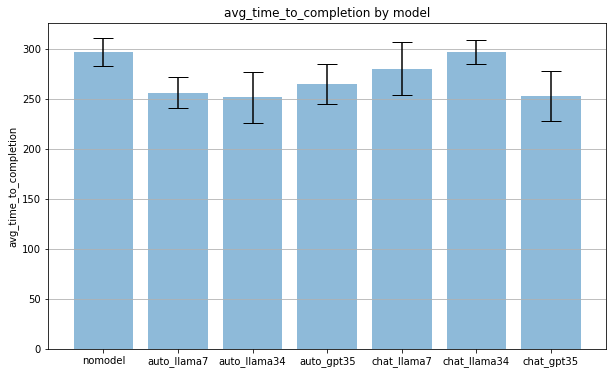

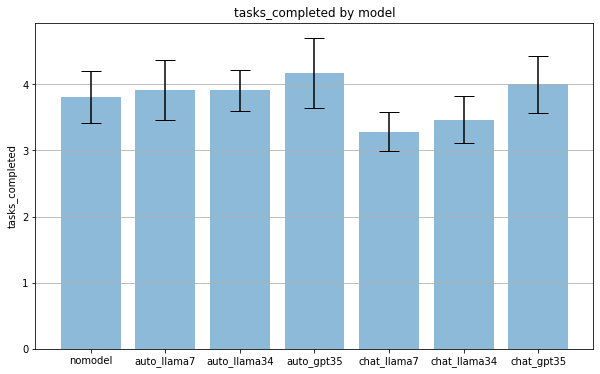

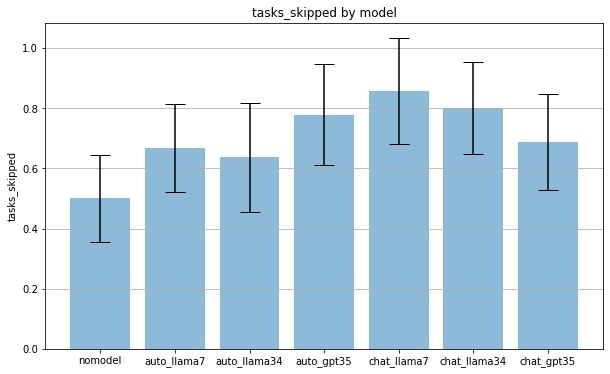

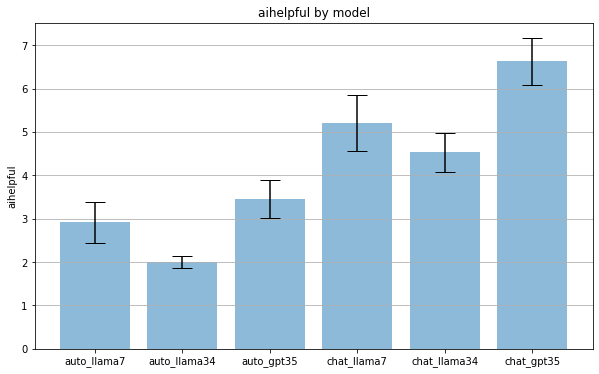

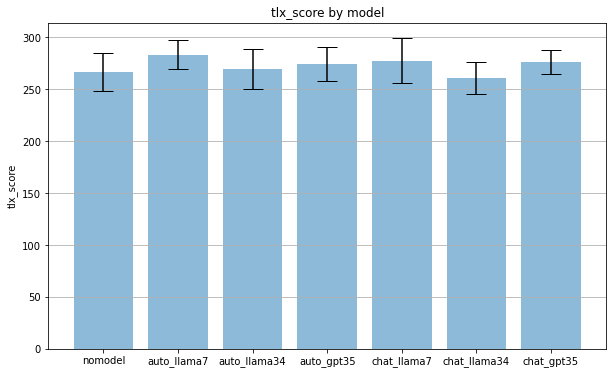

In [35]:
import matplotlib.pyplot as plt
metric = 'avg_time_to_completion'
def operation_to_perform(array):
    # nan median and not mean
    return np.nanmean(array)


def print_chart_metric(metric):
    if metric  in nomodel_metrics:
        models = ['nomodel', 'auto_llama7', 'auto_llama34', 'auto_gpt35', 'chat_llama7', 'chat_llama34', 'chat_gpt35']
        means = [operation_to_perform(nomodel_metrics[metric]), operation_to_perform(autocomplete_llama7_metrics[metric]), operation_to_perform(autocomplete_llama34_metrics[metric]), operation_to_perform(autoocomplete_gpt35_metrics[metric]), operation_to_perform(chat_llama7_metrics[metric]), operation_to_perform(chat_llama34_metrics[metric]), operation_to_perform(chat_gpt35_metrics[metric])]
        std_errors = [np.nanstd(nomodel_metrics[metric]), np.nanstd(autocomplete_llama7_metrics[metric]), np.nanstd(autocomplete_llama34_metrics[metric]), np.nanstd(autoocomplete_gpt35_metrics[metric]), np.nanstd(chat_llama7_metrics[metric]), np.nanstd(chat_llama34_metrics[metric]), np.nanstd(chat_gpt35_metrics[metric])]
    else:
        models = ['auto_llama7', 'auto_llama34', 'auto_gpt35', 'chat_llama7', 'chat_llama34', 'chat_gpt35']
        means = [operation_to_perform(autocomplete_llama7_metrics[metric]), operation_to_perform(autocomplete_llama34_metrics[metric]), operation_to_perform(autoocomplete_gpt35_metrics[metric]), operation_to_perform(chat_llama7_metrics[metric]), operation_to_perform(chat_llama34_metrics[metric]), operation_to_perform(chat_gpt35_metrics[metric])]
        std_errors = [np.nanstd(autocomplete_llama7_metrics[metric]), np.nanstd(autocomplete_llama34_metrics[metric]), np.nanstd(autoocomplete_gpt35_metrics[metric]), np.nanstd(chat_llama7_metrics[metric]), np.nanstd(chat_llama34_metrics[metric]), np.nanstd(chat_gpt35_metrics[metric])]
    stds = [x / np.sqrt(autoocomplete_gpt35_metrics['num_responses']) for x in std_errors]
    fig, ax = plt.subplots()
    ax.bar(models, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(metric)
    ax.set_xticks(models)
    ax.set_xticklabels(models)
    ax.set_title(f'{metric} by model')
    ax.yaxis.grid(True)
    # make the plot wider
    fig.set_size_inches(10, 6)
    # save 
    plt.savefig(f'./saved_plots/{metric}_by_model.png')

print_chart_metric('avg_time_to_completion')
print_chart_metric('tasks_completed')
print_chart_metric('tasks_skipped')
print_chart_metric('aihelpful')
print_chart_metric('tlx_score')


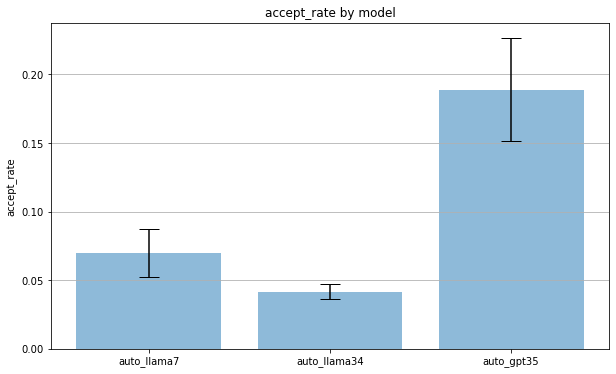

In [30]:
import matplotlib.pyplot as plt
def operation_to_perform(array):
    # nan median and not mean
    return np.nanmean(array)

def print_chart_metric(metric):

    models = ['auto_llama7', 'auto_llama34', 'auto_gpt35']
    means = [operation_to_perform(autocomplete_llama7_metrics[metric]), operation_to_perform(autocomplete_llama34_metrics[metric]), operation_to_perform(autoocomplete_gpt35_metrics[metric])]
    std_errors = [np.nanstd(autocomplete_llama7_metrics[metric]), np.nanstd(autocomplete_llama34_metrics[metric]), np.nanstd(autoocomplete_gpt35_metrics[metric])]
    stds = [x / np.sqrt(autoocomplete_gpt35_metrics['num_responses']) for x in std_errors]
    fig, ax = plt.subplots()
    ax.bar(models, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(metric)
    ax.set_xticks(models)
    ax.set_xticklabels(models)
    ax.set_title(f'{metric} by model')
    ax.yaxis.grid(True)
    # make the plot wider
    fig.set_size_inches(10, 6)
    # save 
    plt.savefig(f'./saved_plots/{metric}_by_model.png')

print_chart_metric('accept_rate')

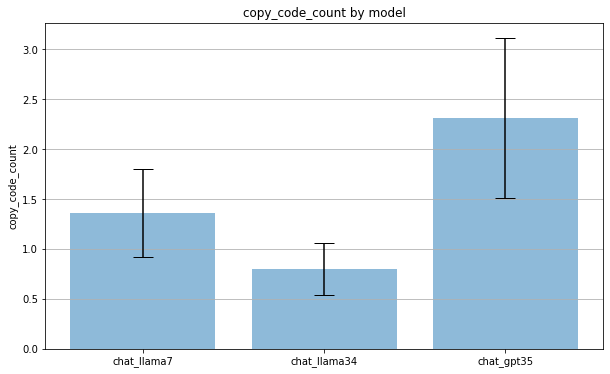

In [31]:
import matplotlib.pyplot as plt
def operation_to_perform(array):
    # nan median and not mean
    return np.nanmean(array)

def print_chart_metric(metric):
    models = ['chat_llama7', 'chat_llama34', 'chat_gpt35']
    means = [operation_to_perform(chat_llama7_metrics[metric]), operation_to_perform(chat_llama34_metrics[metric]), operation_to_perform(chat_gpt35_metrics[metric])]
    std_errors = [np.nanstd(chat_llama7_metrics[metric]), np.nanstd(chat_llama34_metrics[metric]), np.nanstd(chat_gpt35_metrics[metric])]
    stds = [x / np.sqrt(autoocomplete_gpt35_metrics['num_responses']) for x in std_errors]
    fig, ax = plt.subplots()
    ax.bar(models, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(metric)
    ax.set_xticks(models)
    ax.set_xticklabels(models)
    ax.set_title(f'{metric} by model')
    ax.yaxis.grid(True)
    # make the plot wider
    fig.set_size_inches(10, 6)
    # save 
    plt.savefig(f'./saved_plots/{metric}_by_model.png')

print_chart_metric('copy_code_count')